import 程式庫


In [1]:
from database import Database
from get_data import Data
from factor_analysis import *
from plot import Plot
from backtest import *
from datetime import datetime
from combinations import sim_conditions
from report import Report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from dataframe import CustomDataFrame



In [2]:
# 建立取得資料物件
data = Data()

In [49]:
# 取得收盤價資料(回測用)
close = data.get("price:close")
# 取得ROE財報資料(因子分析/進出場策略用)
roe = data.get("report:roe")
pb = data.get("report:pb")
eps = data.get("report:eps")
mom = data.get("report:mom")

In [50]:
# 比較三種不同方法雙因子的api
def sim_3_diff_method(
    factor_name_list,
    factor_ratio_dict,
    factor_asc_dict,
    data,
    quantile=4,
    quantile_th=1,
    show="multi",
    all_factor_df_dict=None,
):
    """
    INPUTS:
        factor_df_dict: 目標因子的df
        factor_ratio_dict:
        factor_asc_dict: 決定因子是越大(F)/小(T)越好, 因子的排序方向
        data: 決定因子是越大(F)/小(T)越好, 因子的排序方向
        quantile: 決定因子是越大(F)/小(T)越好, 因子的排序方向
        quantile_th
        all_factor_df_dict: dictionary中預先存放所有因子資料的DF集合，以便這輪需用到
    RETURN:
        interpolated_df: 計算完因子內插值後的dataframe

    FUNCTION:
        以ROW為基準，計算每一ROW的內插值，最大1最小0
    """
    # 執行因子分析
    result_AA = factor_analysis_two_factor_AA(
        factor_name_list, factor_asc_dict, quantile, all_factor_df_dict
    )
    result_INTERPOLATED = cal_factor_sum_df_interpolated(
        factor_name_list,
        factor_ratio_dict,
        factor_asc_dict,
        quantile,
        all_factor_df_dict,
    )
    result_AND = factor_analysis_two_factor(
        factor_name_list, factor_asc_dict, quantile, all_factor_df_dict
    )
    # 選取第幾分位
    quantile_th = "Quantile_" + str(quantile_th)
    postion_AA = result_AA[quantile_th]
    postion_INTERPOLATED = result_INTERPOLATED[quantile_th]
    postion_AND = result_AND[quantile_th]
    # 執行回測
    sim_result_AA = sim(postion_AA, resample="Q", data=data)
    sim_result_INTERPOLATED = sim(postion_INTERPOLATED, resample="Q", data=data)
    sim_result_AND = sim(postion_AND, resample="Q", data=data)

    if show == "single":
        # 畫圖
        # 創建一個圖表和子圖
        fig, ax = plt.subplots()
        # 在第一個子圖中繪製第一個 DataFrame 的 "cum_returns" 列
        sim_result_AA.stock_data["cum_returns"].plot(ax=ax, label="aa_method_result")
        # 在第一個子圖中繪製第二個 DataFrame 的 "cum_returns" 列
        sim_result_INTERPOLATED.stock_data["cum_returns"].plot(
            ax=ax, label="interpolated_method_result"
        )
        # 在第一個子圖中繪製第四個 DataFrame 的 "cum_returns" 列
        sim_result_AND.stock_data["cum_returns"].plot(ax=ax, label="and_method_result")
        # 添加圖例
        ax.legend()
        # 顯示圖表
        plt.show()

    else:
        cum_returns_AA = sim_result_AA.stock_data["cum_returns"]
        cum_returns_AA.name = "method_AA"
        cum_returns_INTERPOLATED = sim_result_INTERPOLATED.stock_data["cum_returns"]
        cum_returns_INTERPOLATED.name = "method_INTERPOLATED"
        cum_returns_AND = sim_result_AND.stock_data["cum_returns"]
        cum_returns_AND.name = "method_AND"
        # 回傳tuple
        return (cum_returns_AA, cum_returns_INTERPOLATED, cum_returns_AND)

In [51]:
# 假設我要驗證這N個因子
factor_name = ["EPS", "PE", "ROE", "PB", "PS", "ROIC"]
# factor_name = ["EPS", "PE"]

In [52]:
# 自動建立因子DF
all_factor_df_dict = {}
for f in factor_name:
    key = f
    value = data.get("report:" + f)
    all_factor_df_dict[key] = value

In [53]:
# 建立因子權重、排序方向
factor_ratio_dict = {
    "EPS": 0.5,
    "PE": 0.5,
    "ROE": 0.5,
    "PB": 0.5,
    "PS": 0.5,
    "ROIC": 0.5,
}
factor_asc_dict = {
    "EPS": False,
    "PE": True,
    "ROE": False,
    "PB": True,
    "PS": True,
    "ROIC": False,
}

目前正在實作: EPS + EPS 因子組合


KeyError: 'Quantile_6'

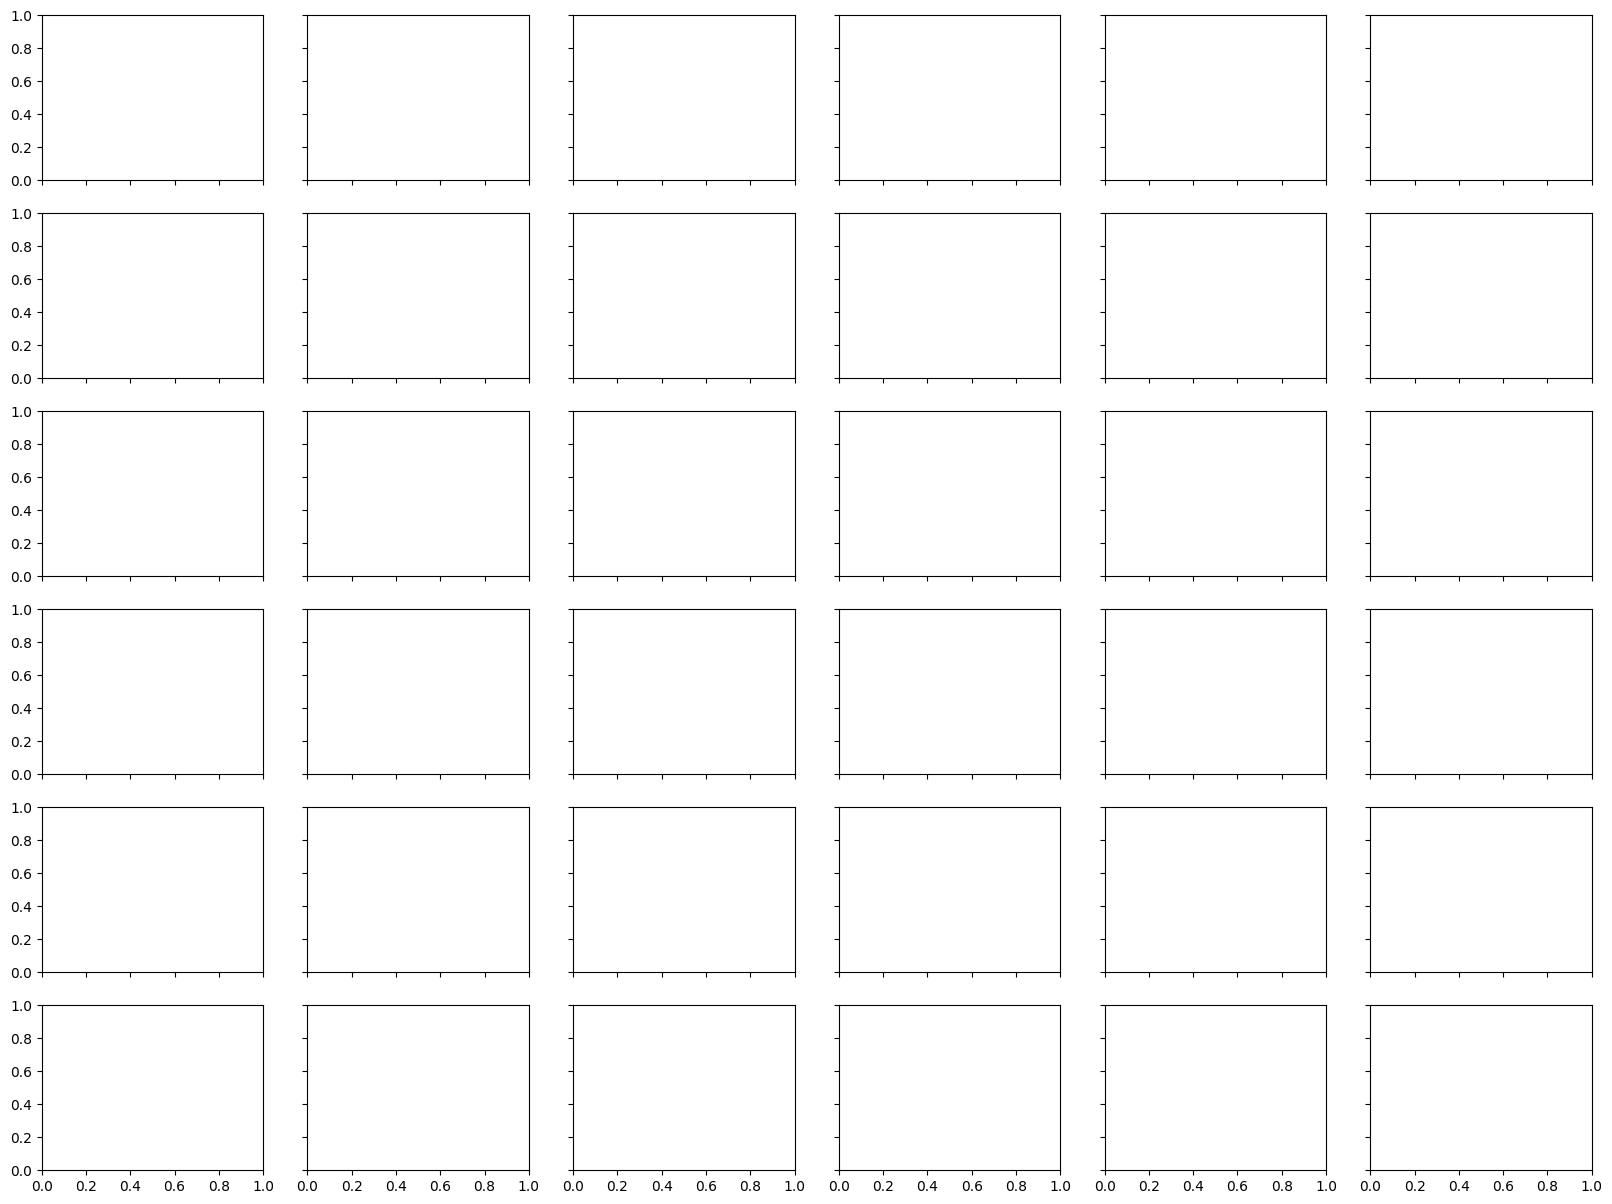

In [54]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# 因子的數量
num_of_factor = len(factor_name)
# 創建一個 NXN 的多圖布局
fig, axes = plt.subplots(
    nrows=num_of_factor, ncols=num_of_factor, figsize=(20, 15), sharex=True, sharey=True
)

# 使用迴圈遍歷每個子圖
for i in range(num_of_factor):
    for j in range(num_of_factor):
        # if i == j:
        #     continue
        # 記錄第1、2個因子
        factor_1 = factor_name[i]
        factor_2 = factor_name[j]
        factor_name_list = []
        factor_name_list = [factor_1, factor_2]
        print("目前正在實作:", factor_1, "+", factor_2, "因子組合")
        # factor_df_dict = {}
        # factor_df_dict = generate_factor_df(factor_1, factor_2)
        # print("factor_df_dict", factor_df_dict)
        # 呼叫回測三種雙因子的API
        cum_returns_AA, cum_returns_INTERPOLATED, cum_returns_AND = sim_3_diff_method(
            factor_name_list,
            factor_ratio_dict,
            factor_asc_dict,
            data,
            quantile=4,
            quantile_th=6,
            show="multi",
            all_factor_df_dict=all_factor_df_dict,
        )
        # 在每個子圖上畫折線圖，將 data 改成 custom_data
        sns.lineplot(
            x=cum_returns_AA.index,
            y=cum_returns_AA,
            ax=axes[i, j],
            label=cum_returns_AA.name,
        )
        sns.lineplot(
            x=cum_returns_INTERPOLATED.index,
            y=cum_returns_INTERPOLATED,
            ax=axes[i, j],
            label=cum_returns_INTERPOLATED.name,
        )
        sns.lineplot(
            x=cum_returns_AND.index,
            y=cum_returns_AND,
            ax=axes[i, j],
            label=cum_returns_AND.name,
        )

        # 可以自行調整子圖的標題等
        axes[i, j].set_title("Factor_" + factor_name[i] + "_" + factor_name[j])

# 調整整體布局
plt.tight_layout()
plt.show()

In [ ]:
factor_name = ["EPS", "PE"]

In [ ]:
a, b, c = sim_3_diff_method(
    factor_name,
    factor_ratio_dict,
    factor_asc_dict,
    data,
    quantile=4,
    quantile_th=4,
    show="multi",
    all_factor_df_dict=all_factor_df_dict,
)

In [ ]:
a

date
2000-06-30    1.000000
2000-07-01    1.000000
2000-07-02    1.000000
2000-07-03    1.000000
2000-07-04    1.000000
                ...   
2023-03-27    4.270367
2023-03-28    4.238533
2023-03-29    4.261778
2023-03-30    4.277147
2023-03-31    4.272080
Freq: D, Name: method_AA, Length: 8310, dtype: float64

In [ ]:
# # 呼叫Achieving Alpha的雙因子方法
# result_AA = factor_analysis_two_factor_AA(factor_df_dict, factor_asc_dict)
# # 呼叫台股研究室的內積加權法cal_factor_sum_df_interpolated()
# result_INTERPOLATED = cal_factor_sum_df_interpolated(factor_df_dict, factor_ratio_dict, factor_asc_dict)
# # 呼叫根據Quantile 執行AND運算
# result_AND = factor_analysis_two_factor(factor_df_dict, factor_asc_dict)

In [ ]:
# # 計算每一行值為 True 的數量
# counts_1 = result["Quantile_1"].sum(axis=1)
# counts_2 = result["Quantile_2"].sum(axis=1)
# counts_3 = result["Quantile_3"].sum(axis=1)
# counts_4 = result["Quantile_4"].sum(axis=1)

# df = pd.concat([counts_1, counts_2, counts_3, counts_4], axis=1)
# df.plot()

# 將四個區間帶入回測，換股周期為:季
# sim_result = sim(postion, resample="Q")
# interpolated_method_result = sim(interpolated_method_result, resample="Q")
# and_method_result = sim(and_method_result, resample="Q")

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

# 假設你有九組因子資料，每組有三條線
# 請替換這裡的資料，使用你的真實資料
factor_data = {
    "Factor1": np.random.randn(100).cumsum(),
    "Factor2": np.random.randn(100).cumsum(),
    "Factor3": np.random.randn(100).cumsum(),
    "Factor4": np.random.randn(100).cumsum(),
    "Factor5": np.random.randn(100).cumsum(),
    "Factor6": np.random.randn(100).cumsum(),
    "Factor7": np.random.randn(100).cumsum(),
    "Factor8": np.random.randn(100).cumsum(),
    "Factor9": np.random.randn(100).cumsum(),
}

# Create a subplot with 3 rows and 3 columns
fig = make_subplots(
    rows=3, cols=3, subplot_titles=[f"Factor {i}" for i in range(1, 10)]
)

# Add traces for each factor
for i, (factor_name, factor_series) in enumerate(factor_data.items(), start=1):
    row = (i - 1) // 3 + 1
    col = (i - 1) % 3 + 1
    trace = go.Scatter(
        x=np.arange(100), y=factor_series, mode="lines", name=factor_name + "_Line1"
    )
    fig.add_trace(trace, row=row, col=col)

    trace = go.Scatter(
        x=np.arange(100), y=factor_series + 5, mode="lines", name=factor_name + "_Line2"
    )
    fig.add_trace(trace, row=row, col=col)

    trace = go.Scatter(
        x=np.arange(100), y=factor_series - 5, mode="lines", name=factor_name + "_Line3"
    )
    fig.add_trace(trace, row=row, col=col)

# Update layout
fig.update_layout(
    title_text="Line Plots for Different Factors",
    showlegend=True,
)

# Show the plot
fig.show()